In [23]:
import pandas as pd


In [24]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

# Read the OBS with the ObsDataset API (from Peter and Ewan)

To get the `import obsdata` to work, pip-install that package from `https://github.com/ecmwf-lab/ai-obs-experimental-data/tree/mihai/gnn/obsdata`.

Alternatively, you can try to use my virtual environment. On the ATOS, do 

```shell
$> module load python3/new
$> module load gcc/12.2.0
$> module load nvidia/24.1
$> source ~syma/venvs/aifs+obs/bin/activate
```

I selected three datasets:

1/ Meteosat-8 (SEVIRI), a geostationary satellite dataset (brightness temperatures)

2/ METAR: t2m point observations (at airports)

3/ NOAA 20 ATMS, a polar-orbiting satellite (brightness temperatures)

One row of the dataframes corresponds to a multi-channel (or multi-var) obs at a single lat/lon location.
Observations are denoted by the prefix `obsvalue_`. The rest of the features represent metadata.

In [25]:
from anemoi.datasets import open_dataset

from obsdata.dataset.obs_dataset import ObsDataset
from obsdata.visualization.plotting_utils import plot_map_df

## Note

The user must provide the path to the datasets in the config:

```shell
$ cat  ~/.config/anemoi/settings.toml 
[datasets]
path = [
        "/home/mlx/ai-ml/datasets",
        "/home/mlx/ai-ml/observations/v1",
]
```

In [26]:
!cat config.yaml

observations: # for now "observations" must be on top level
  multiple: # automatically pad the datasets with the min and max dates
    - dataset: observations-od-ai-0001-2017-2022-meteosat-8-iodc-seviri-v1
      frequency: 6h             # this may become optional
      rename_prefix: "seviri"   # this may become optional
      is_observations: true     # will desappear
    - dataset: observations-ea-ofb-0001-2004-2023-combined-metar-v1
      frequency: 6h             # this may become optional
      rename_prefix: "land"     # this may become optional
      is_observations: true     # will disappear
    - dataset: observations-ea-ofb-0001-2018-2023-noaa-20-atms-radiances-v1
      frequency: 6h              # this may become optional
      rename_prefix: "noaa_atms" # this may become optional
      is_observations: true      # will desappear
    - dataset: aifs-ea-an-oper-0001-mars-o96-1979-2022-6h-v6
      start: 2004-11-09 00:00:00
      end: 2023-12-31 00:00:00


In [27]:
with open("config.yaml", "r") as f:
    import yaml
    import pprint
    cfg = yaml.safe_load(f)
    pprint.pp(cfg)

{'observations': {'multiple': [{'dataset': 'observations-od-ai-0001-2017-2022-meteosat-8-iodc-seviri-v1',
                                'frequency': '6h',
                                'rename_prefix': 'seviri',
                                'is_observations': True},
                               {'dataset': 'observations-ea-ofb-0001-2004-2023-combined-metar-v1',
                                'frequency': '6h',
                                'rename_prefix': 'land',
                                'is_observations': True},
                               {'dataset': 'observations-ea-ofb-0001-2018-2023-noaa-20-atms-radiances-v1',
                                'frequency': '6h',
                                'rename_prefix': 'noaa_atms',
                                'is_observations': True},
                               {'dataset': 'aifs-ea-an-oper-0001-mars-o96-1979-2022-6h-v6',
                                'start': datetime.datetime(2004, 11, 9, 0, 0),
            

## Note

The `anemoi.datasets` are defined around the concept of "valid time". The "valid time" of an observation window is (for now) chosen to be the _end of the window_.
So, an observation window with `frequency=6h` and a "valid time" of `2020-01-01 06:00` will contain all observations in `[00z - 06z]` for Jan 1, 2020.

The date ranges used to create the `ObsDataset` below are not quite the same (namely, the "start" point is slightly different).

In [28]:
ds_seviri = ObsDataset(
    "/home/mlx/ai-ml/observations/v1/observations-od-ai-0001-2017-2022-meteosat-8-iodc-seviri-v1.zarr",
    202001010000, # !!! start = 202001010000 means the 1st window will be [00, 06z], Jan 1, 2020, i.e. same as the anemoi-dataset
    202012311800,
    len_hrs=6,
    normalize=False,
)

ds_metar = ObsDataset(
    "/home/mlx/ai-ml/observations/v1/observations-ea-ofb-0001-2004-2023-combined-metar-v1.zarr",
    202001010000,
    202012311800,
    len_hrs=6,
    normalize=False,
)

ds_noaa_atms = ObsDataset(
    "/home/mlx/ai-ml/observations/v1/observations-ea-ofb-0001-2018-2023-noaa-20-atms-radiances-v1.zarr",
    202001010000,
    202012311800,
    len_hrs=6,
    normalize=False,
)

In [29]:
df_seviri = ds_seviri.get_df(0)
df_metar = ds_metar.get_df(0)
df_noaa_atms = ds_noaa_atms.get_df(0)

display(df_seviri.head(5))
display(df_metar.head(5))
display(df_noaa_atms.head(5))

healpix_idx_8  satellite_identifier      lat        lon     zenith  \
0          357.0                  55.0 -0.21483  84.770287  49.916767   
1          357.0                  55.0 -0.21449  84.069580  49.139225   
2          357.0                  55.0 -0.21416  83.380676  48.373459   
3          357.0                  55.0 -0.21384  82.702988  47.618919   
4          357.0                  55.0 -0.21353  82.036003  46.875095   

   obsvalue_rawbt_4  obsvalue_rawbt_5  obsvalue_rawbt_6  obsvalue_rawbt_7  \
0        293.799988        233.000000        252.600006        283.500000   
1        292.600006        233.000000        251.500000        283.500000   
2        278.500000        228.300003        240.399994        262.799988   
3        259.500000        224.000000        232.699997        241.000000   
4        262.000000        223.000000        231.699997        245.000000   

   obsvalue_rawbt_8  ...  sin_julian_day  cos_local_time  sin_local_time  \
0        264.600006  ...        0.000717       -0.169698        0.985496   
1        264.799988  ...        0.000717       -0.157634        0.987498   
2        250.699997  ...        0.000717       -0.145749        0.989322   
3        235.399994  ...        0.000717       -0.134038        0.990976   
4        238.600006  ...        0.000717       -0.122493        0.992469   

    cos_sza  cos_latitude  sin_latitude  cos_longitude  sin_longitude  \
0  0.146034      0.999993     -0.003749       0.091149       0.995837   
1  0.134908      0.999993     -0.003744       0.103321       0.994648   
2  0.123951      0.999993     -0.003738       0.115272       0.993334   
3  0.113154      0.999993     -0.003732       0.127013       0.991901   
4  0.102512      0.999993     -0.003727       0.138551       0.990355   

    cos_vza            datetime  
0  0.643900 2020-01-01 01:00:00  
1  0.654223 2020-01-01 01:00:00  
2  0.664273 2020-01-01 01:00:00  
3  0.674058 2020-01-01 01:00:00  
4  0.683591 2020-01-01 01:00:00  

[5 rows x 26 columns]

healpix_idx_8      seqno        lat        lon  stalt       lsm  \
0          715.0  8319730.0 -62.189999 -58.990002   44.0  0.230274   
1          737.0  8319731.0 -54.840000 -68.309998   21.0  0.707107   
2          737.0  8319732.0 -53.779999 -67.750000   22.0  0.570816   
3          737.0  8319733.0 -53.000000 -70.849998   37.0  0.401767   
4          737.0  8319734.0 -51.619999 -69.279999   19.0  0.843836   

   obsvalue_t2m_0  obsvalue_u10m_0  obsvalue_v10m_0  obsvalue_rh2m_0  ...  \
0      274.200012         4.936345        -2.850000         1.000000  ...   
1      283.200012        -0.000000        -0.000000         0.662682  ...   
2      283.200012         2.635429        -3.140782         0.816081  ...   
3      283.200012         1.778505        -4.886402         0.710711  ...   
4      284.200012        -0.984808        -0.173648         0.874698  ...   

   cos_julian_day  sin_julian_day  cos_local_time  sin_local_time  cos_sza  \
0        0.999998         0.00215        0.970338       -0.241753      0.0   
1        0.999998         0.00215        0.918377       -0.395706      0.0   
2        0.999998         0.00215        0.922201       -0.386711      0.0   
3        0.999998         0.00215        0.899939       -0.436017      0.0   
4        0.999998         0.00215        0.911547       -0.411196      0.0   

   cos_latitude  sin_latitude  cos_longitude  sin_longitude  \
0      0.466541     -0.884500       0.515188      -0.857077   
1      0.575862     -0.817547       0.369585      -0.929197   
2      0.590887     -0.806754       0.378649      -0.925541   
3      0.601815     -0.798636       0.328042      -0.944663   
4      0.620874     -0.783910       0.353801      -0.935321   

             datetime  
0 2020-01-01 03:00:00  
1 2020-01-01 03:00:00  
2 2020-01-01 03:00:00  
3 2020-01-01 03:00:00  
4 2020-01-01 03:00:00  

[5 rows x 21 columns]

healpix_idx_8      seqno        lat        lon   cos_vza  obsvalue_rawbt_1  \
0            8.0  5060180.0  11.422421  33.982182  0.468431        274.134186   
1          285.0  5060188.0  12.407173  28.671408  0.764261        279.992706   
2          287.0  5060208.0  13.962142  18.433941  0.804946        283.581909   
3          286.0  5060210.0  14.150439  16.962812  0.713556        278.269470   
4          308.0  5060214.0  14.695867  12.263958  0.464031        258.962646   

   obsvalue_rawbt_2  obsvalue_rawbt_3  obsvalue_rawbt_4  obsvalue_rawbt_5  \
0        269.584534        274.660126        272.345612        262.324371   
1        277.071747        275.879822        276.143921        270.272217   
2        281.516113        278.181183        277.973755        271.458832   
3        275.987427        275.950714        275.763855        268.965942   
4        255.432159        271.606232        269.877045        260.541504   

   ...  cos_julian_day  sin_julian_day  cos_local_time  sin_local_time  \
0  ...             1.0        0.000002        0.828886        0.559417   
1  ...             1.0        0.000002        0.877106        0.480296   
2  ...             1.0        0.000002        0.948505        0.316763   
3  ...             1.0        0.000002        0.956324        0.292307   
4  ...             1.0        0.000002        0.977056        0.212984   

   cos_sza  cos_latitude  sin_latitude  cos_longitude  sin_longitude  \
0      0.0      0.980194      0.198041       0.829211       0.558935   
1      0.0      0.976645      0.214858       0.877386       0.479786   
2      0.0      0.970455      0.241281       0.948689       0.316211   
3      0.0      0.969657      0.244469       0.956494       0.291751   
4      0.0      0.967286      0.253688       0.977179       0.212416   

             datetime  
0 2020-01-01 00:00:08  
1 2020-01-01 00:00:08  
2 2020-01-01 00:00:08  
3 2020-01-01 00:00:08  
4 2020-01-01 00:00:08  

[5 rows x 37 columns]

In [30]:
# how many obs records do we have? (not all channel values are necessarily "valid", as ObsData doesn't do any NaN filtering etc.)
len(df_seviri), len(df_metar), len(df_noaa_atms)

(226535 (226_535), 3276 (3_276), 18815 (18_815))

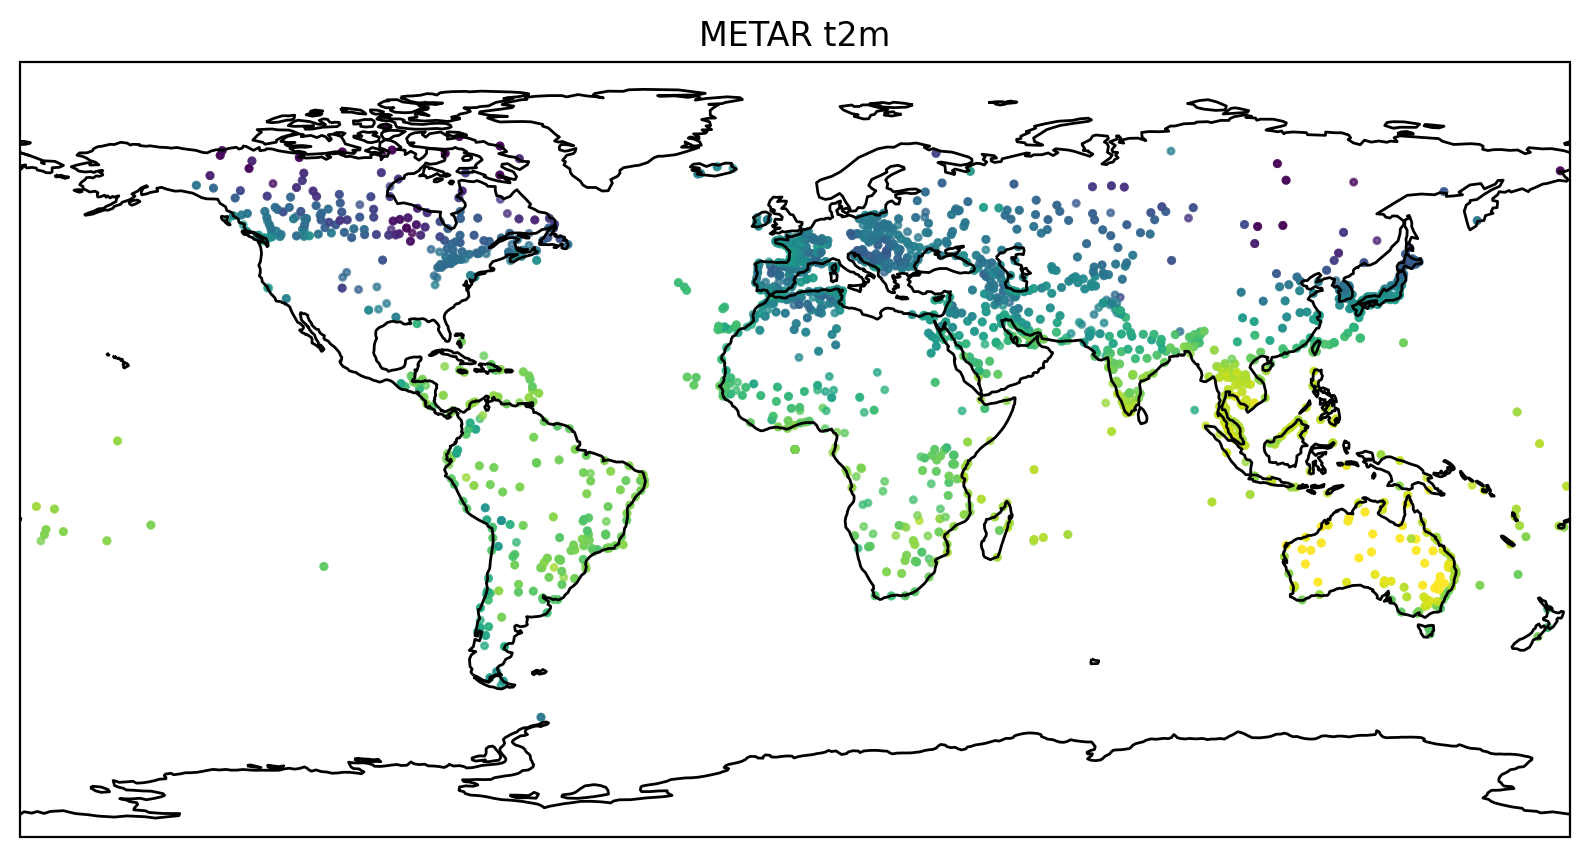

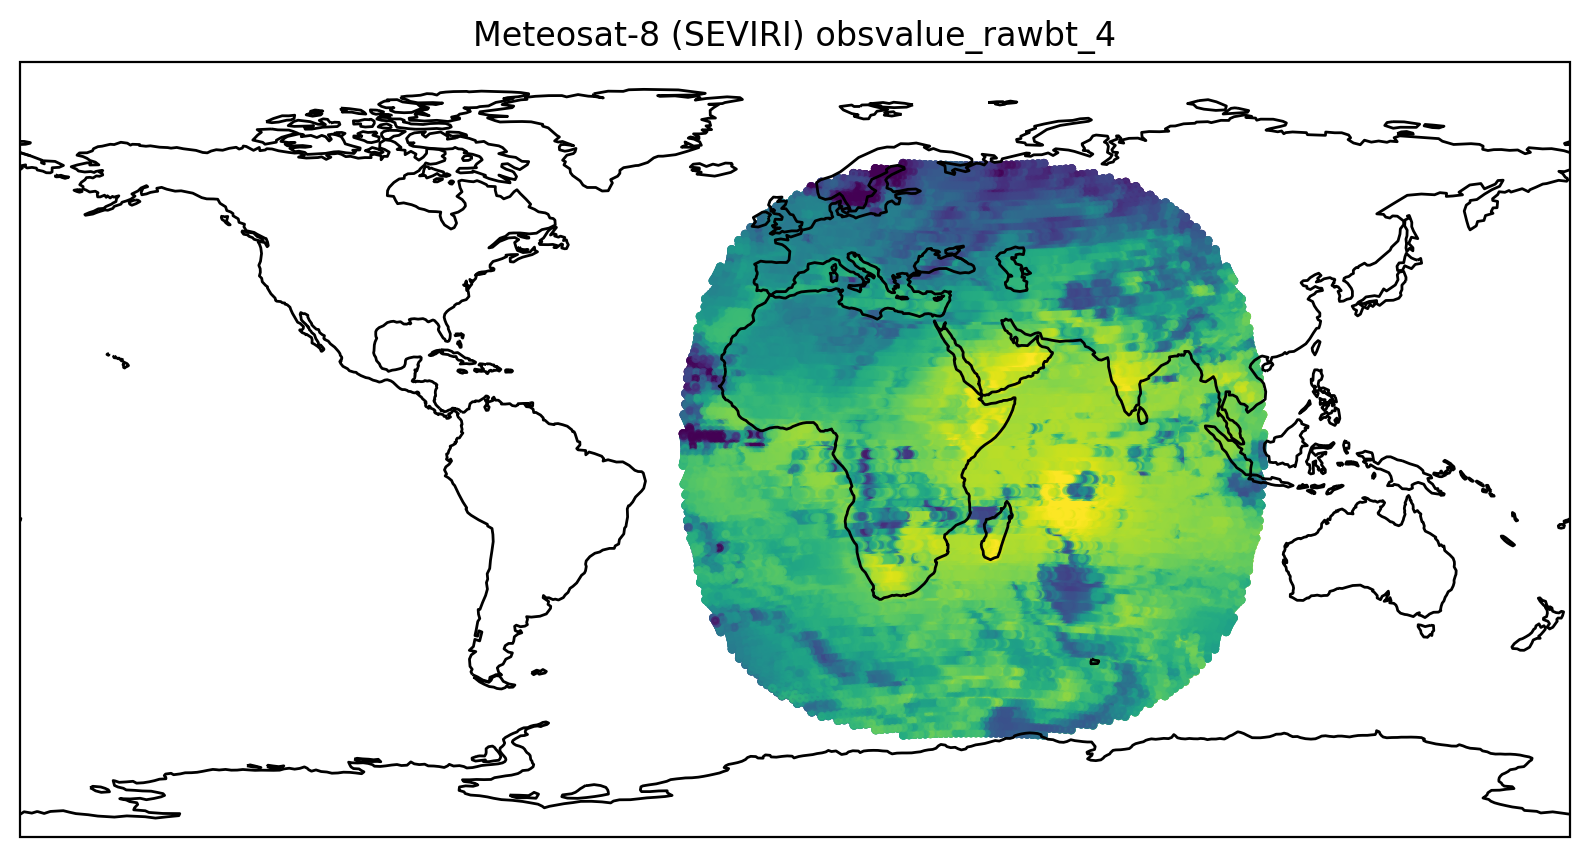

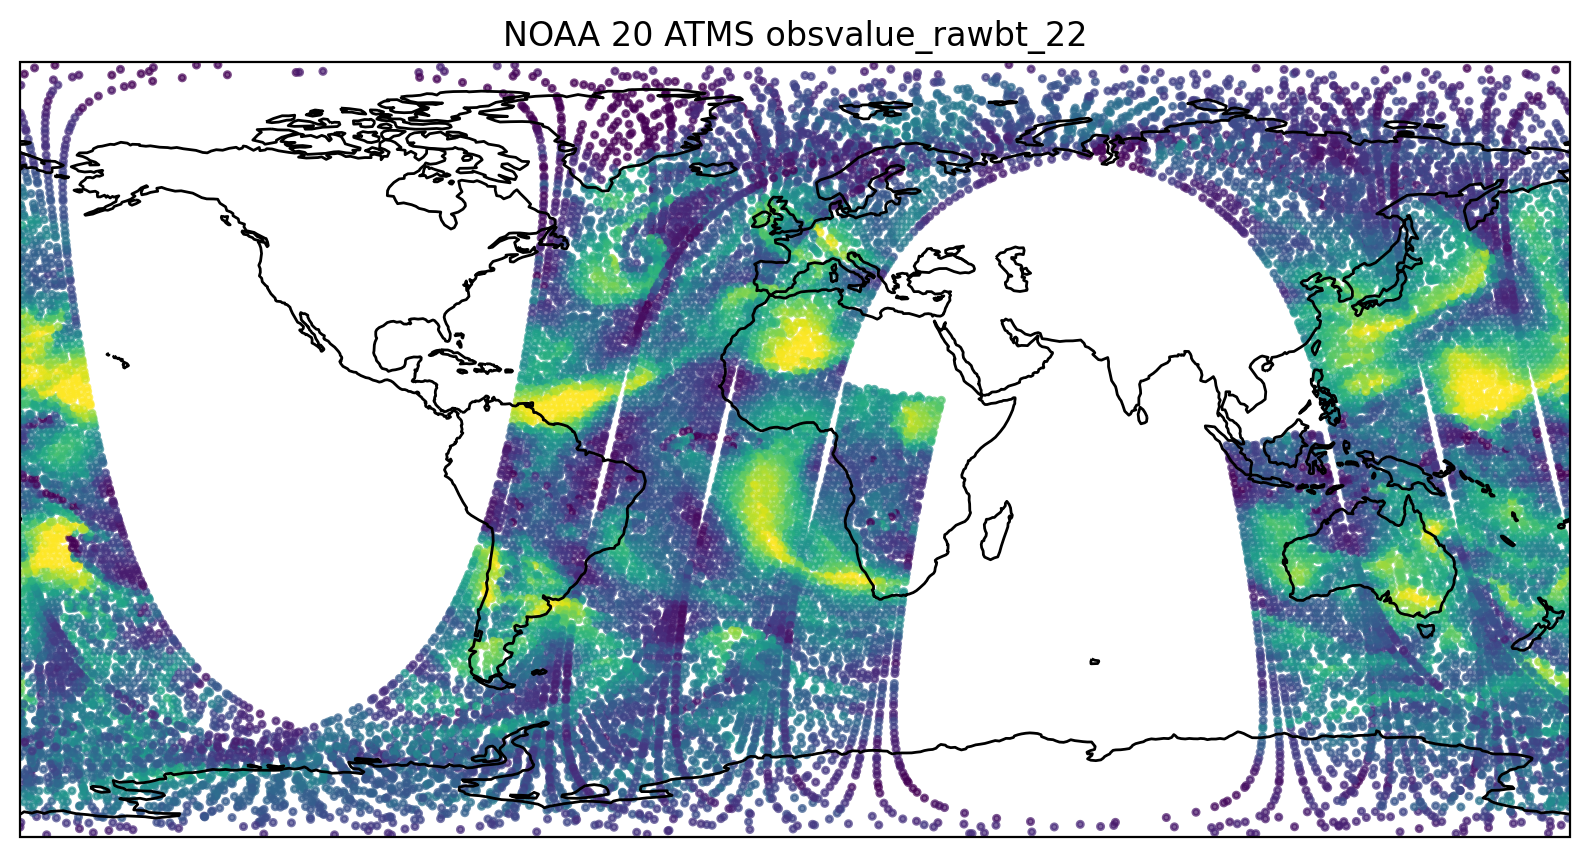

In [31]:
plot_map_df(df_metar, "obsvalue_t2m_0", title="METAR t2m", figsize=(10, 6))
plot_map_df(df_seviri, "obsvalue_rawbt_4", title="Meteosat-8 (SEVIRI) obsvalue_rawbt_4", figsize=(10, 6))
plot_map_df(df_noaa_atms, "obsvalue_rawbt_22", title="NOAA 20 ATMS obsvalue_rawbt_22", figsize=(10, 6))

In [32]:
def str_(t):
    """ Not needed, but useful for debugging """
    import numpy as np

    if isinstance(t, (list, tuple)):
        return "[" + " , ".join(str_(e) for e in t) + "]"
    if isinstance(t, np.ndarray):
        return str(t.shape).replace(" ", "").replace(",", "-")
    if isinstance(t, dict):
        return "{" + " , ".join(f"{k}: {str_(v)}" for k, v in t.items()) + "}"
    return str(t)

In [33]:
ds = open_dataset(cfg)

print(f"✅ Initialized the ERA5 + OBS dataset with {len(ds)} items ...")
print(f"Dates: {ds.dates[0]}, {ds.dates[1]}, ..., {ds.dates[-2]}, {ds.dates[-1]}")

✅ Initialized the ERA5 + OBS dataset with 28009 items ...
Dates: 2004-03-30 00:00:00, 2004-03-30 06:00:00, ..., 2023-05-31 18:00:00, 2023-06-01 00:00:00


In [34]:
idx =  ds.dates.index(pd.Timestamp("2020-01-01 06:00:00"))

date = ds.dates[idx]
data = ds[idx]
print(f"✅ Got item {idx} for time window ending {date}: shapes = {str_(data)}")

✅ Got item 23021 for time window ending 2020-01-01 06:00:00: shapes = [(25-1-226535) , (20-1-3276) , (36-1-18815) , (101-1-40320)]


In [35]:
assert data[0].shape[-1] == len(df_seviri), f"SEVIRI obs counts do not match! Anemoi has {data[0].shape[-1]} while ObsDataset has {len(df_seviri)}!"
assert data[1].shape[-1] == len(df_metar), f"METAR obs counts do not match! Anemoi has {data[1].shape[-1]} while ObsDataset has {len(df_seviri)}!"
assert data[2].shape[-1] == len(df_noaa_atms), f"NOAA ATMS obs counts do not match! Anemoi has {data[2].shape[-1]} while ObsDataset has {len(df_seviri)}!"

In [36]:
anemoi_metar = pd.DataFrame(
    data=data[1].squeeze(axis=1).T,
    columns=df_metar.columns[:-1]
)
anemoi_metar.head(5)

healpix_idx_8      seqno        lat        lon  stalt       lsm  \
0          715.0  8319730.0 -62.189999 -58.990002   44.0  0.230274   
1          737.0  8319731.0 -54.840000 -68.309998   21.0  0.707107   
2          737.0  8319732.0 -53.779999 -67.750000   22.0  0.570816   
3          737.0  8319733.0 -53.000000 -70.849998   37.0  0.401767   
4          737.0  8319734.0 -51.619999 -69.279999   19.0  0.843836   

   obsvalue_t2m_0  obsvalue_u10m_0  obsvalue_v10m_0  obsvalue_rh2m_0  \
0      274.200012         4.936345        -2.850000         1.000000   
1      283.200012        -0.000000        -0.000000         0.662682   
2      283.200012         2.635429        -3.140782         0.816081   
3      283.200012         1.778505        -4.886402         0.710711   
4      284.200012        -0.984808        -0.173648         0.874698   

   obsvalue_ps_0  cos_julian_day  sin_julian_day  cos_local_time  \
0        99580.0        0.999998         0.00215        0.970338   
1       100950.0        0.999998         0.00215        0.918377   
2       101140.0        0.999998         0.00215        0.922201   
3       100960.0        0.999998         0.00215        0.899939   
4       101170.0        0.999998         0.00215        0.911547   

   sin_local_time  cos_sza  cos_latitude  sin_latitude  cos_longitude  \
0       -0.241753      0.0      0.466541     -0.884500       0.515188   
1       -0.395706      0.0      0.575862     -0.817547       0.369585   
2       -0.386711      0.0      0.590887     -0.806754       0.378649   
3       -0.436017      0.0      0.601815     -0.798636       0.328042   
4       -0.411196      0.0      0.620874     -0.783910       0.353801   

   sin_longitude  
0      -0.857077  
1      -0.929197  
2      -0.925541  
3      -0.944663  
4      -0.935321

In [37]:
anemoi_noaa_atms = pd.DataFrame(
    data=data[2].squeeze(axis=1).T,
    columns=df_noaa_atms.columns[:-1]
)
anemoi_noaa_atms.head(5)

healpix_idx_8      seqno        lat        lon   cos_vza  obsvalue_rawbt_1  \
0            8.0  5060180.0  11.422421  33.982182  0.468431        274.134186   
1          285.0  5060188.0  12.407173  28.671408  0.764261        279.992706   
2          287.0  5060208.0  13.962142  18.433941  0.804946        283.581909   
3          286.0  5060210.0  14.150439  16.962812  0.713556        278.269470   
4          308.0  5060214.0  14.695867  12.263958  0.464031        258.962646   

   obsvalue_rawbt_2  obsvalue_rawbt_3  obsvalue_rawbt_4  obsvalue_rawbt_5  \
0        269.584534        274.660126        272.345612        262.324371   
1        277.071747        275.879822        276.143921        270.272217   
2        281.516113        278.181183        277.973755        271.458832   
3        275.987427        275.950714        275.763855        268.965942   
4        255.432159        271.606232        269.877045        260.541504   

   ...  obsvalue_rawbt_22  cos_julian_day  sin_julian_day  cos_local_time  \
0  ...         256.217529             1.0        0.000002        0.828886   
1  ...         252.451935             1.0        0.000002        0.877106   
2  ...         248.986969             1.0        0.000002        0.948505   
3  ...         250.657089             1.0        0.000002        0.956324   
4  ...         242.757965             1.0        0.000002        0.977056   

   sin_local_time  cos_sza  cos_latitude  sin_latitude  cos_longitude  \
0        0.559417      0.0      0.980194      0.198041       0.829211   
1        0.480296      0.0      0.976645      0.214858       0.877386   
2        0.316763      0.0      0.970455      0.241281       0.948689   
3        0.292307      0.0      0.969657      0.244469       0.956494   
4        0.212984      0.0      0.967286      0.253688       0.977179   

   sin_longitude  
0       0.558935  
1       0.479786  
2       0.316211  
3       0.291751  
4       0.212416  

[5 rows x 36 columns]

In [38]:
anemoi_seviri = pd.DataFrame(
    data=data[0].squeeze(axis=1).T,
    columns=df_seviri.columns[:-1]
)
anemoi_seviri.head(5)

healpix_idx_8  satellite_identifier      lat        lon     zenith  \
0          357.0                  55.0 -0.21483  84.770287  49.916767   
1          357.0                  55.0 -0.21449  84.069580  49.139225   
2          357.0                  55.0 -0.21416  83.380676  48.373459   
3          357.0                  55.0 -0.21384  82.702988  47.618919   
4          357.0                  55.0 -0.21353  82.036003  46.875095   

   obsvalue_rawbt_4  obsvalue_rawbt_5  obsvalue_rawbt_6  obsvalue_rawbt_7  \
0        293.799988        233.000000        252.600006        283.500000   
1        292.600006        233.000000        251.500000        283.500000   
2        278.500000        228.300003        240.399994        262.799988   
3        259.500000        224.000000        232.699997        241.000000   
4        262.000000        223.000000        231.699997        245.000000   

   obsvalue_rawbt_8  ...  cos_julian_day  sin_julian_day  cos_local_time  \
0        264.600006  ...             1.0        0.000717       -0.169698   
1        264.799988  ...             1.0        0.000717       -0.157634   
2        250.699997  ...             1.0        0.000717       -0.145749   
3        235.399994  ...             1.0        0.000717       -0.134038   
4        238.600006  ...             1.0        0.000717       -0.122493   

   sin_local_time   cos_sza  cos_latitude  sin_latitude  cos_longitude  \
0        0.985496  0.146034      0.999993     -0.003749       0.091149   
1        0.987498  0.134908      0.999993     -0.003744       0.103321   
2        0.989322  0.123951      0.999993     -0.003738       0.115272   
3        0.990976  0.113154      0.999993     -0.003732       0.127013   
4        0.992469  0.102512      0.999993     -0.003727       0.138551   

   sin_longitude   cos_vza  
0       0.995837  0.643900  
1       0.994648  0.654223  
2       0.993334  0.664273  
3       0.991901  0.674058  
4       0.990355  0.683591  

[5 rows x 25 columns]

In [39]:
df_metar.columns

Index(['healpix_idx_8', 'seqno', 'lat', 'lon', 'stalt', 'lsm',
       'obsvalue_t2m_0', 'obsvalue_u10m_0', 'obsvalue_v10m_0',
       'obsvalue_rh2m_0', 'obsvalue_ps_0', 'cos_julian_day', 'sin_julian_day',
       'cos_local_time', 'sin_local_time', 'cos_sza', 'cos_latitude',
       'sin_latitude', 'cos_longitude', 'sin_longitude', 'datetime'],
      dtype='object')

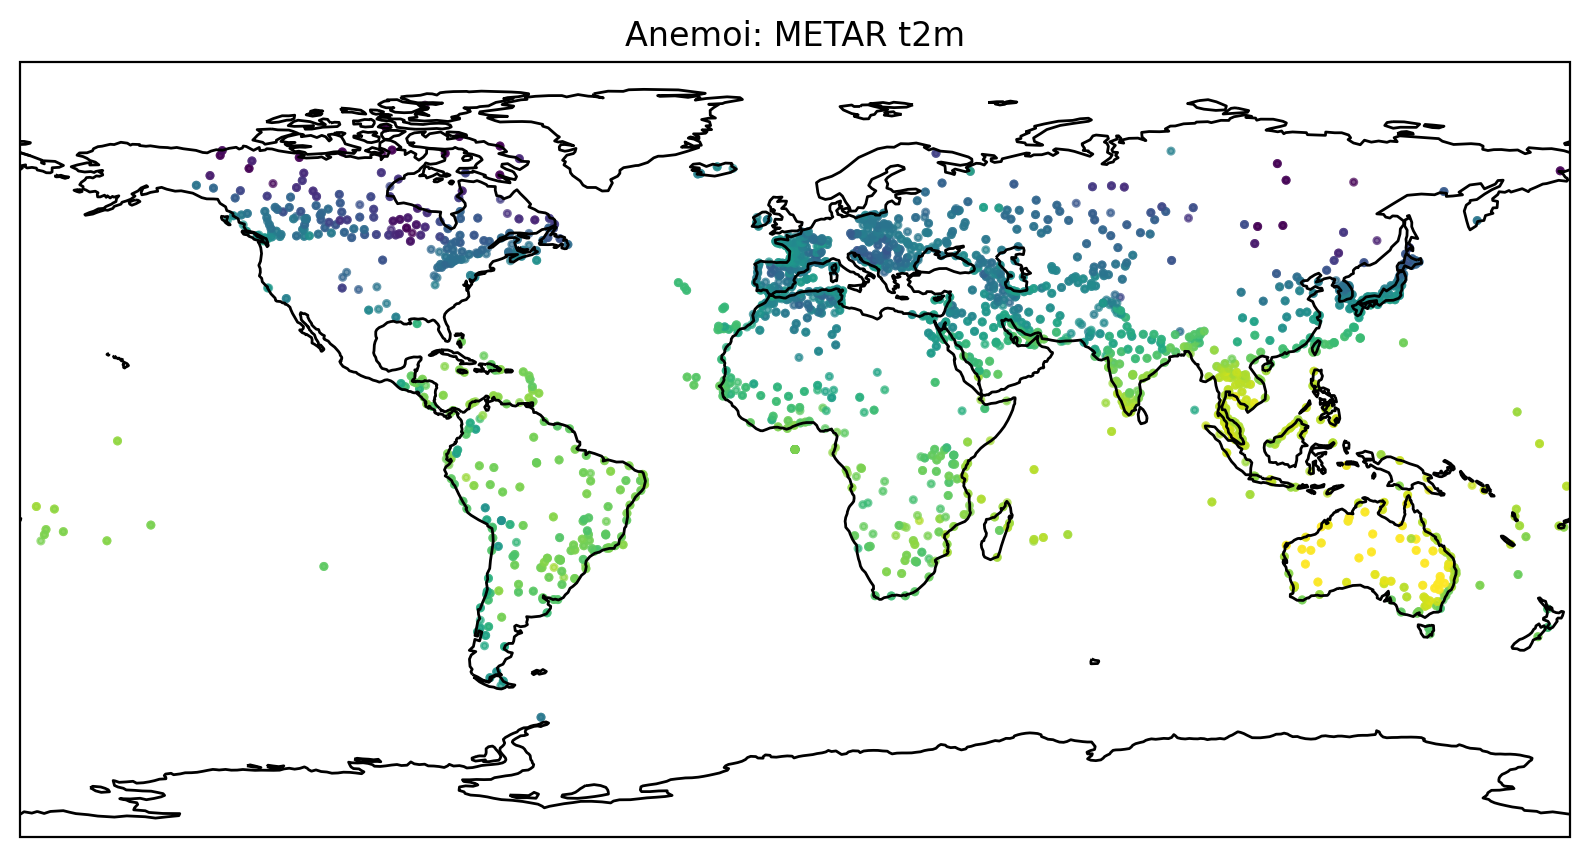

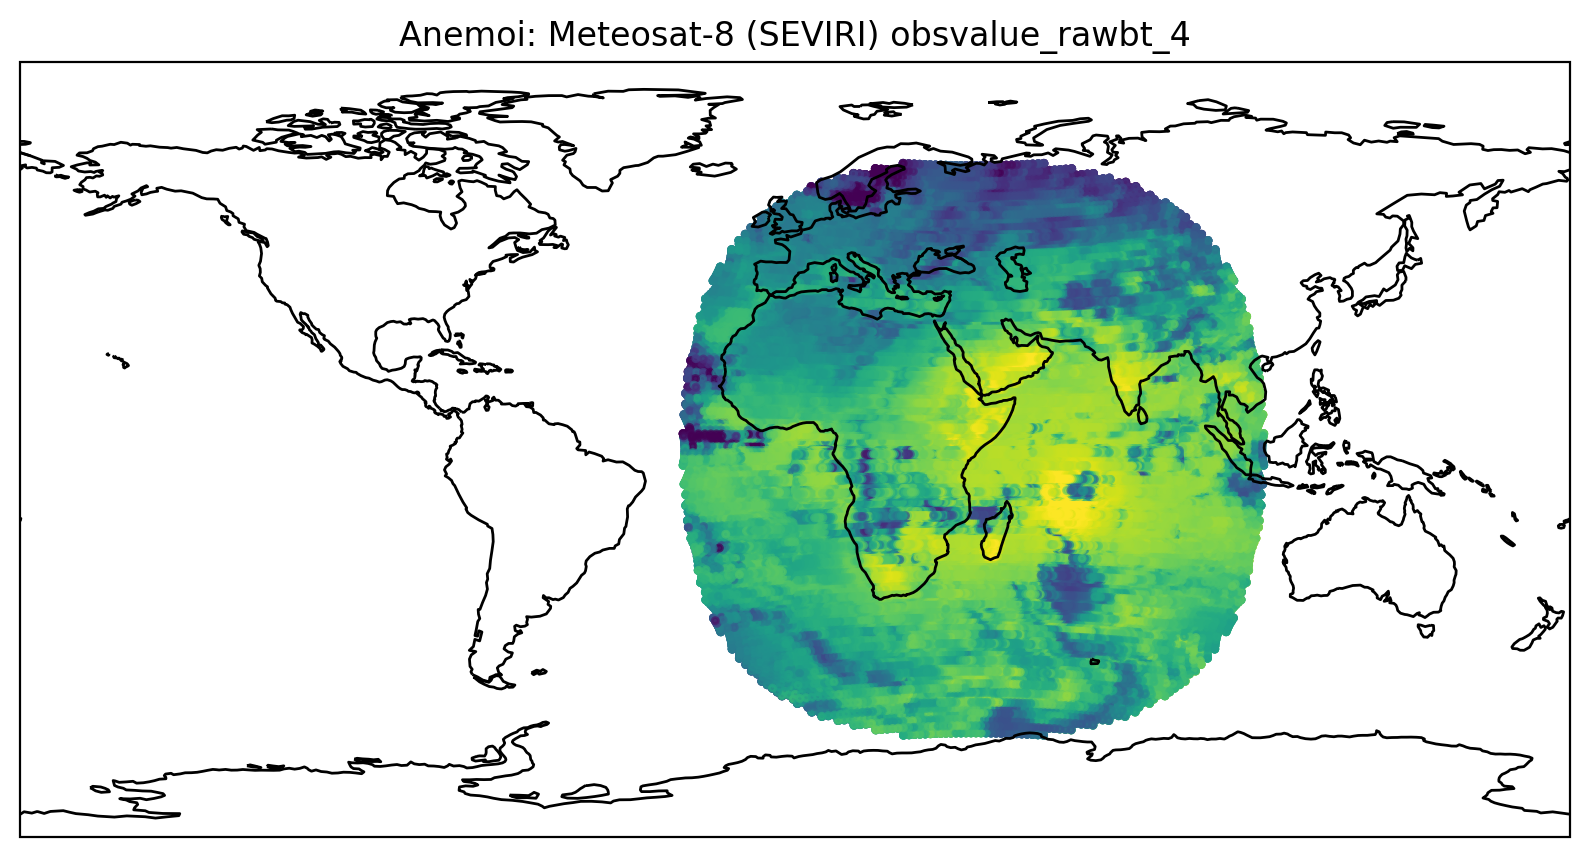

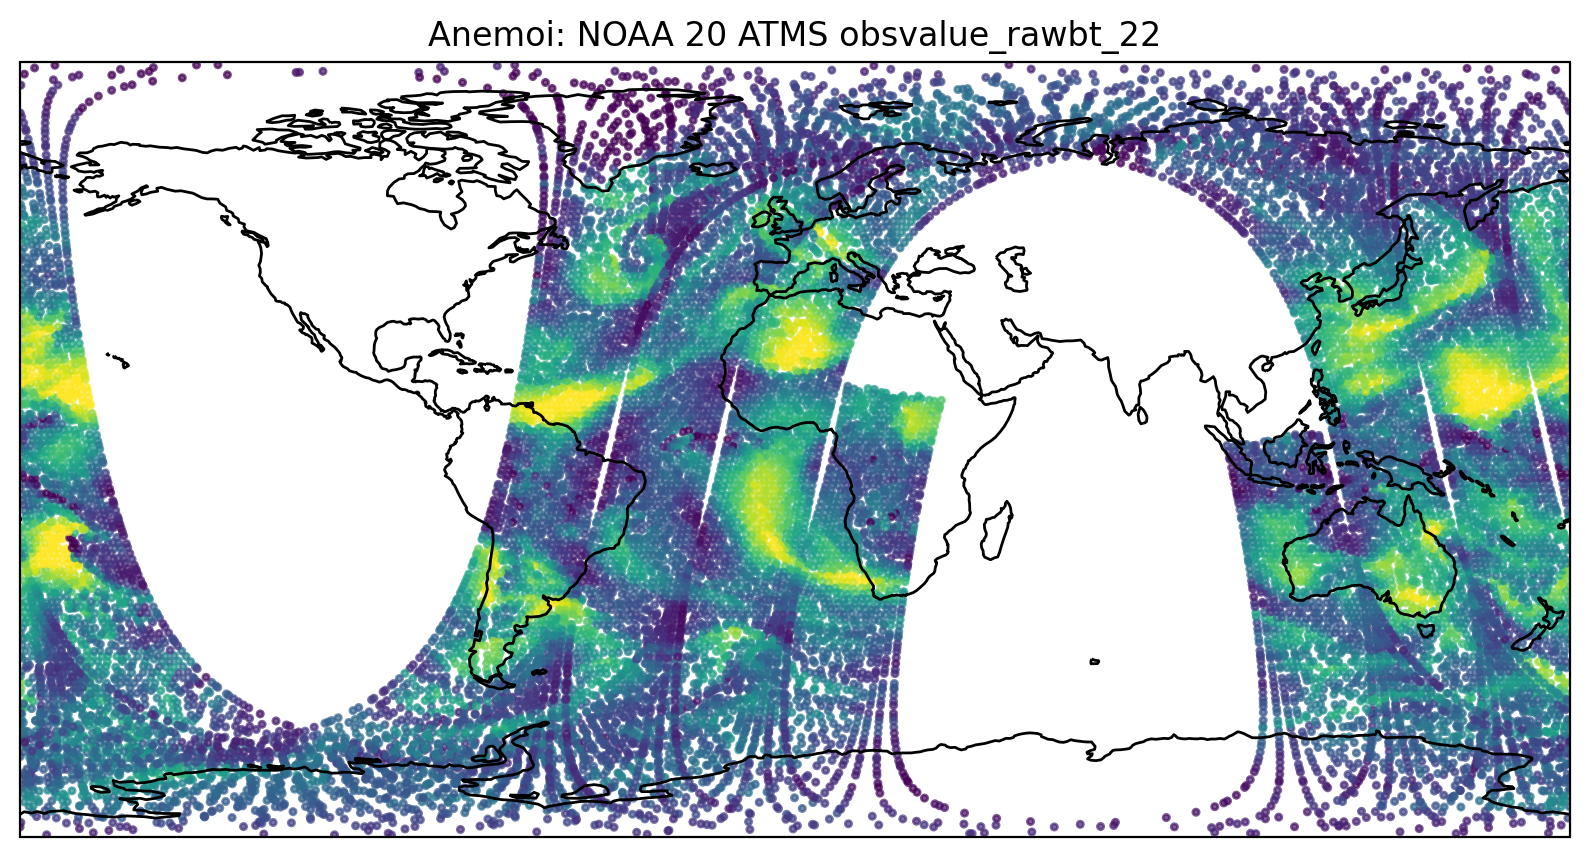

In [40]:
plot_map_df(anemoi_metar, "obsvalue_t2m_0", title="Anemoi: METAR t2m", figsize=(10, 6))
plot_map_df(anemoi_seviri, "obsvalue_rawbt_4", title="Anemoi: Meteosat-8 (SEVIRI) obsvalue_rawbt_4", figsize=(10, 6))
plot_map_df(anemoi_noaa_atms, "obsvalue_rawbt_22", title="Anemoi: NOAA 20 ATMS obsvalue_rawbt_22", figsize=(10, 6))

In [41]:
import numpy as np

assert np.nanmax(np.abs(anemoi_metar.values - df_metar.values[:, :-1])) <= 0.0, "Numerical differences between the two METAR datasets?"
assert np.nanmax(np.abs(anemoi_seviri.values - df_seviri.values[:, :-1])) <= 0.0, "Numerical differences between the two SEVIRI datasets?"
assert np.nanmax(np.abs(anemoi_noaa_atms.values - df_noaa_atms.values[:, :-1])) <= 0.0, "Numerical differences between the two NOAA ATMS datasets?"

## A simple model

I demonstrate below how we might use these data with a very simple, "4x-encoder" neural network model.

First impressions:

1/ The ensemble dimension seems a bit cumbersome, we may want to get rid of it (e.g., specify in the config that we don't want it)

2/ The current shapes are `(channels, latlons)`; it'd probably be easier to work with a "channels-last" tensor, i.e. shape=`(latlons, channels)`.

In [42]:
from collections import OrderedDict
import torch
from torch import nn

class DummyEncoderModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoders = nn.ModuleDict()
        self.encoders['metar'] = nn.Linear(20, 64)
        self.encoders['noaa-atms'] = nn.Linear(36, 64)
        self.encoders['seviri'] = nn.Linear(25, 64)
        self.encoders['era'] = nn.Linear(101, 64)

        self.mixer = nn.Linear(64, 64)

    def forward(self, x: OrderedDict) -> OrderedDict:
        y = OrderedDict()
        
        for rt in x:
            y[rt] = self.encoders[rt](x[rt])

        return self.mixer(torch.cat([yt for (_, yt) in y.items()]))

In [43]:
dummy_model = DummyEncoderModel()
dummy_model.train()

x = OrderedDict()

x["seviri"] = torch.from_numpy(data[0].squeeze(axis=1).T)
x["metar"] = torch.from_numpy(data[1].squeeze(axis=1).T)
x["noaa-atms"] = torch.from_numpy(data[2].squeeze(axis=1).T)
x["era"] = torch.from_numpy(data[3].squeeze(axis=1).T)

y = dummy_model(x)

print(f"Model input shapes: {[obs.upper() + ': ' + str(list(x_in.shape)) for (obs, x_in) in x.items()]}")
print(f"Model output shape: {list(y.shape)}")
assert y.shape == (sum([data[i].shape[-1] for i in range(len(data))]), 64)

Model input shapes: ['SEVIRI: [226535, 25]', 'METAR: [3276, 20]', 'NOAA-ATMS: [18815, 36]', 'ERA: [40320, 101]']
Model output shape: [288946, 64]


# TODO

There are still important questions left to answer:

1/ Would this play well with the `DataIndices` and `Normalizers` and `Imputer` classes in AIFS?

2/ Would the design make it "easy" to assign input features to the encoder modules? E.g., have an encoder yaml config like so:

```yaml
atms-encoder:
    - sin_latitude
    - cos_latitude
    # ... other metadata
    - noaa_atms_obsvalue_rawbt_2
    - noaa_atms_obsvalue_rawbt_3
    # ... other noaa-atms channels
    - npp_atms_obsvalue_rawbt_2
    - npp_atms_obsvalue_rawbt_3
    # ... other npp atms channels
```

3/ Inference?